In [1]:
#Import Modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Path the file locations of the csv files
gdp = "../data/original/gpd_states.csv"
unem = "../data/original/Unemployment_States_Annual.csv"

#Convert csv files into dataframes
gdp_df = pd.read_csv(gdp)
unem_df = pd.read_csv(unem, index_col =0)

In [3]:
#Drop the unwanted row
drop_gdp = gdp_df.drop(0)
drop_gdp.head()
drop_gdp = drop_gdp.set_index(["GeoName"])

In [4]:
#Get the states into a list for future referance
state_list = [ "Alabama", "Arkansas", 
            "Arizona", "California", "Colorado", "Connecticut", 
            "District of Columbia", "Delaware", "Florida", "Georgia", 
            "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", 
            "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", 
            "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", 
            "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", 
            "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", 
            "Rhode Island", "South Carolina", "South Dakota", "Tennessee", 
            "Texas", "Utah", "Virginia", "Vermont", "Washington", 
            "Wisconsin", "West Virginia", "Wyoming"]

In [5]:
#Locate the first state in our data
gdp_data = pd.DataFrame(drop_gdp.loc["Alaska",:])

#container for loop appending
state_cont = []

#Loop to get repeating state name in column and setting up new loop
for x in range(len(gdp_data)):
    state_cont.append(gdp_data.columns[0])
gdp_data["GeoName"] = state_cont
gdp_data = gdp_data.set_index(["GeoName",gdp_data.index]) 
gdp_data.columns=["GDP"]

#Iterate through all states to get data in a preferred format for mongodb
for state in state_list:

    gdp_new = pd.DataFrame(drop_gdp.loc[state,:])

    state_cont = []

    for x in range(len(gdp_new)):
        state_cont.append(gdp_new.columns[0])
    gdp_new["GeoName"] = state_cont
    gdp_new = gdp_new.set_index(["GeoName",gdp_new.index])
    gdp_new.columns=["GDP"]
    gdp_data = gdp_data.append(gdp_new)
gdp_data   

GDP
GeoName              
Alaska  2011  56896.3
        2012  58283.6
        2013  57247.7
        2014  56484.9
        2015  51490.9
...               ...
Wyoming 2017  36863.7
        2018  39032.3
        2019  39600.8
        2020  36323.5
        2021  41622.4

[561 rows x 1 columns]

In [6]:
#Locate the first state in our data
unem_data = pd.DataFrame(unem_df.T.loc["Alaska",:])

#container for loop appending
state_cont = []

#Loop to get repeating state name in column and setting up new loop
for x in range(len(unem_data)):
    state_cont.append(unem_data.columns[0])
unem_data["State"] = state_cont
unem_data = unem_data.set_index(["State",unem_data.index]) 
unem_data.columns=["Unemployment Rate"]

#Iterate through all states to get data in a preferred format for mongodb
for state in state_list:

    unem_new = pd.DataFrame(unem_df.T.loc[state,:])

    state_cont = []

    for x in range(len(unem_new)):
        state_cont.append(unem_new.columns[0])
    unem_new["State"] = state_cont
    unem_new = unem_new.set_index(["State",unem_new.index])
    unem_new.columns=["Unemployment Rate"]
    unem_data = unem_data.append(unem_new)
unem_data  

Unemployment Rate
State   DATE                   
Alaska  2011                7.8
        2012                7.2
        2013                7.0
        2014                6.7
        2015                6.3
...                         ...
Wyoming 2017                4.3
        2018                4.1
        2019                3.7
        2020                5.8
        2021                4.5

[561 rows x 1 columns]

In [7]:
#Rename index header and give empty header a name
gdp_data.index.names = ['State', 'DATE']

In [8]:
#Give all columns the same data type for a merge to be possible
level=1
unem_data.index = unem_data.index.set_levels(unem_data.index.levels[level].astype(str),level=level)

In [9]:
#initial merge
combo_df = pd.merge(unem_data, gdp_data, how = "outer", on = ["State","DATE"])
combo_df.to_csv("../data/unem_gdp.csv")

In [10]:
#checking data types for merge
print(unem_data.index.dtypes)
print("-------------------")
print(combo_df.index.dtypes)

State    object
DATE     object
dtype: object
-------------------
State    object
DATE     object
dtype: object


In [11]:
#Path to clean files for final merge
edu = "../data/education.csv"
crime = "../data/prisoners_rate.csv"
# inf = "../data/inflation.csv"

#Convert csv files into dataframes and give both 
edu_df = pd.read_csv(edu)
crime_df = pd.read_csv(crime, index_col = [0,1])
# inflation_df = pd.read_csv(inf, index_col = 0)
edu_df = edu_df.set_index(["State","DATE"])

#Give all columns the same data type for a merge to be possible
level=1
edu_df.index = edu_df.index.set_levels(edu_df.index.levels[level].astype(str),level=level)
crime_df.index = crime_df.index.set_levels(crime_df.index.levels[level].astype(str),level=level)

In [12]:
#Merging above dataframes with previously created dataframes
final_df = pd.merge(edu_df, combo_df, how = "outer", on = ["State","DATE"])
final_df = final_df.dropna()

#Final merge with all tracked metrics included
actual_final = pd.merge(final_df, crime_df, how = "outer", on = ["State","DATE"])
actual_final = actual_final.dropna()
actual_final

College  High School  Unemployment Rate      GDP  \
State   DATE                                                     
Alaska  2011     26.4         91.8                7.8  56896.3   
        2012     28.0         92.0                7.2  58283.6   
        2013     28.0         91.6                7.0  57247.7   
        2014     28.0         92.9                6.7  56484.9   
        2015     29.7         92.6                6.3  51490.9   
...               ...          ...                ...      ...   
Wyoming 2016     27.1         93.2                5.4  35879.0   
        2017     27.6         92.9                4.3  36863.7   
        2018     26.9         93.3                4.1  39032.3   
        2019     29.1         94.5                3.7  39600.8   
        2020     28.2         93.8                5.8  36323.5   

              Incarceration rate  Inflation Rate  
State   DATE                                      
Alaska  2011           13.232104             3.2  
        2012           26.831053             2.1  
        2013            7.578558             1.5  
        2014            9.966688             1.6  
        2015           12.026040             0.1  
...                          ...             ...  
Wyoming 2016           21.611664             1.3  
        2017           24.749793             2.1  
        2018           26.820344             2.4  
        2019           24.930561             1.8  
        2020           10.825753             1.2  

[510 rows x 6 columns]

In [13]:
# actual_final["Unem Score"] = (actual_final["Employment Rate"]*.2)/10
# actual_final["College Score"] = (actual_final["College"]*.25)/10
# actual_final["HS Score"] = (actual_final["High School"]*.05)/10
# actual_final["Money Retention"] = ((actual_final["Inflation Rate"]-100)*-.3)/10
# actual_final["Crime Score"] = (actual_final["Incarceration rate"]*.2)/10
# actual_final["Total"] = actual_final["Money Retention"] + actual_final["Crime Score"] + actual_final["College Score"] + actual_final["HS Score"] + actual_final["Unem Score"]



# test = actual_final["Total"]

actual_final

College  High School  Unemployment Rate      GDP  \
State   DATE                                                     
Alaska  2011     26.4         91.8                7.8  56896.3   
        2012     28.0         92.0                7.2  58283.6   
        2013     28.0         91.6                7.0  57247.7   
        2014     28.0         92.9                6.7  56484.9   
        2015     29.7         92.6                6.3  51490.9   
...               ...          ...                ...      ...   
Wyoming 2016     27.1         93.2                5.4  35879.0   
        2017     27.6         92.9                4.3  36863.7   
        2018     26.9         93.3                4.1  39032.3   
        2019     29.1         94.5                3.7  39600.8   
        2020     28.2         93.8                5.8  36323.5   

              Incarceration rate  Inflation Rate  
State   DATE                                      
Alaska  2011           13.232104             3.2  
        2012           26.831053             2.1  
        2013            7.578558             1.5  
        2014            9.966688             1.6  
        2015           12.026040             0.1  
...                          ...             ...  
Wyoming 2016           21.611664             1.3  
        2017           24.749793             2.1  
        2018           26.820344             2.4  
        2019           24.930561             1.8  
        2020           10.825753             1.2  

[510 rows x 6 columns]

In [14]:
actual_final["Score 1"] = ((actual_final["Inflation Rate"]*-.1)*100)+100
actual_final["Score 2"] = ((actual_final["Unemployment Rate"]*-.1)*100)+100
actual_final["Score 3"] = actual_final["Incarceration rate"].round(0)
actual_final["Score 4"] = (actual_final["College"]*.1).round(1)
actual_final["Score 5"] = (actual_final["High School"]*.01).round(1)
actual_final["Score Total"] = (((actual_final["Score 1"] + actual_final["Score 2"] + actual_final["Score 3"])/300) + actual_final["Score 4"] + actual_final["Score 5"])+2
actual_final

College  High School  Unemployment Rate      GDP  \
State   DATE                                                     
Alaska  2011     26.4         91.8                7.8  56896.3   
        2012     28.0         92.0                7.2  58283.6   
        2013     28.0         91.6                7.0  57247.7   
        2014     28.0         92.9                6.7  56484.9   
        2015     29.7         92.6                6.3  51490.9   
...               ...          ...                ...      ...   
Wyoming 2016     27.1         93.2                5.4  35879.0   
        2017     27.6         92.9                4.3  36863.7   
        2018     26.9         93.3                4.1  39032.3   
        2019     29.1         94.5                3.7  39600.8   
        2020     28.2         93.8                5.8  36323.5   

              Incarceration rate  Inflation Rate  Score 1  Score 2  Score 3  \
State   DATE                                                                  
Alaska  2011           13.232104             3.2     68.0     22.0     13.0   
        2012           26.831053             2.1     79.0     28.0     27.0   
        2013            7.578558             1.5     85.0     30.0      8.0   
        2014            9.966688             1.6     84.0     33.0     10.0   
        2015           12.026040             0.1     99.0     37.0     12.0   
...                          ...             ...      ...      ...      ...   
Wyoming 2016           21.611664             1.3     87.0     46.0     22.0   
        2017           24.749793             2.1     79.0     57.0     25.0   
        2018           26.820344             2.4     76.0     59.0     27.0   
        2019           24.930561             1.8     82.0     63.0     25.0   
        2020           10.825753             1.2     88.0     42.0     11.0   

              Score 4  Score 5  Score Total  
State   DATE                                 
Alaska  2011      2.6      0.9     5.843333  
        2012      2.8      0.9     6.146667  
        2013      2.8      0.9     6.110000  
        2014      2.8      0.9     6.123333  
        2015      3.0      0.9     6.393333  
...               ...      ...          ...  
Wyoming 2016      2.7      0.9     6.116667  
        2017      2.8      0.9     6.236667  
        2018      2.7      0.9     6.140000  
        2019      2.9      0.9     6.366667  
        2020      2.8      0.9     6.170000  

[510 rows x 12 columns]

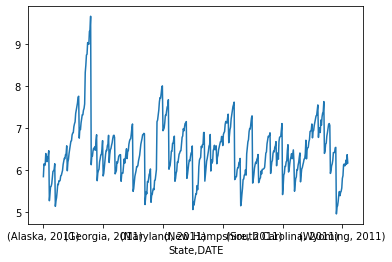

In [15]:
test = actual_final["Score Total"]
test.plot()
plt.show()

In [16]:
actual_final.to_csv("../data/happiness.csv")

In [19]:
actual_final["inf_score"] = actual_final["Score 1"]
actual_final["unem_score"] = actual_final["Score 2"]
actual_final["pris_score"] = actual_final["Score 3"]
actual_final["edu_college"] = actual_final["Score 4"]
actual_final["edu_hs"] = actual_final["Score 5"]
actual_final["happy_score"] = actual_final["Score Total"].round(1)
actual_final

College  High School  Unemployment Rate      GDP  \
State   DATE                                                     
Alaska  2011     26.4         91.8                7.8  56896.3   
        2012     28.0         92.0                7.2  58283.6   
        2013     28.0         91.6                7.0  57247.7   
        2014     28.0         92.9                6.7  56484.9   
        2015     29.7         92.6                6.3  51490.9   
...               ...          ...                ...      ...   
Wyoming 2016     27.1         93.2                5.4  35879.0   
        2017     27.6         92.9                4.3  36863.7   
        2018     26.9         93.3                4.1  39032.3   
        2019     29.1         94.5                3.7  39600.8   
        2020     28.2         93.8                5.8  36323.5   

              Incarceration rate  Inflation Rate  Score 1  Score 2  Score 3  \
State   DATE                                                                  
Alaska  2011           13.232104             3.2     68.0     22.0     13.0   
        2012           26.831053             2.1     79.0     28.0     27.0   
        2013            7.578558             1.5     85.0     30.0      8.0   
        2014            9.966688             1.6     84.0     33.0     10.0   
        2015           12.026040             0.1     99.0     37.0     12.0   
...                          ...             ...      ...      ...      ...   
Wyoming 2016           21.611664             1.3     87.0     46.0     22.0   
        2017           24.749793             2.1     79.0     57.0     25.0   
        2018           26.820344             2.4     76.0     59.0     27.0   
        2019           24.930561             1.8     82.0     63.0     25.0   
        2020           10.825753             1.2     88.0     42.0     11.0   

              Score 4  Score 5  Score Total  inf_score  unem_score  \
State   DATE                                                         
Alaska  2011      2.6      0.9     5.843333       68.0        22.0   
        2012      2.8      0.9     6.146667       79.0        28.0   
        2013      2.8      0.9     6.110000       85.0        30.0   
        2014      2.8      0.9     6.123333       84.0        33.0   
        2015      3.0      0.9     6.393333       99.0        37.0   
...               ...      ...          ...        ...         ...   
Wyoming 2016      2.7      0.9     6.116667       87.0        46.0   
        2017      2.8      0.9     6.236667       79.0        57.0   
        2018      2.7      0.9     6.140000       76.0        59.0   
        2019      2.9      0.9     6.366667       82.0        63.0   
        2020      2.8      0.9     6.170000       88.0        42.0   

              pris_score  edu_college  edu_hs  happy_score  
State   DATE                                                
Alaska  2011        13.0          2.6     0.9          5.8  
        2012        27.0          2.8     0.9          6.1  
        2013         8.0          2.8     0.9          6.1  
        2014        10.0          2.8     0.9          6.1  
        2015        12.0          3.0     0.9          6.4  
...                  ...          ...     ...          ...  
Wyoming 2016        22.0          2.7     0.9          6.1  
        2017        25.0          2.8     0.9          6.2  
        2018        27.0          2.7     0.9          6.1  
        2019        25.0          2.9     0.9          6.4  
        2020        11.0          2.8     0.9          6.2  

[510 rows x 18 columns]

In [20]:
happiness_df = actual_final[["inf_score","unem_score","pris_score","edu_college","edu_hs","happy_score"]]
happiness_df.to_csv("../data/final_happy.csv")